In [1]:
import os
import math
import numpy as np
import pandas as pd
import GPy
import pickle
import random
import torch
import botorch
import gpytorch
import matplotlib.pyplot as plt

from sklearn import metrics, datasets
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import qmc
from collections import Counter
from matplotlib import pyplot as plt
from math import pi
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP,HeteroskedasticSingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize

In [2]:
# em3 = 0.846, em5=1.163, em8=1.423
Em_dict = {3:0.846, 5:1.163, 8:1.423}
m_output = 8
Em = Em_dict[m_output]

In [3]:
def generate_data(N=80):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs, shape N x 1
    F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
    NoiseVar = 2 * np.exp(-(X - 2) ** 2 / 4) + 0.3  # Noise variances
    Y = F + np.random.randn(N, 1) * np.sqrt(NoiseVar)  # Noisy data
    return X, Y, NoiseVar

def sampling_position(num_points, lower_bounds, upper_bounds, seed=0, ):
    sampler = qmc.LatinHypercube(d=len(lower_bounds), seed=seed)
    sample = sampler.random(n=num_points)
    points_position = qmc.scale(sample, lower_bounds, upper_bounds)

    return points_position

def sixhump(x):
    x1 = x[0]
    x2 = x[1]
    z = (4 - 2.1 * x1 ** 2 + x1 ** 4 / 3) * x1 ** 2 + x1 * x2 + (-4 + 4 * x2 ** 2) * x2 ** 2
    sx = np.sqrt(np.abs(x).sum())
    noise = np.random.normal(loc=0, scale=np.abs(x).sum())
    Gx = z + 0.8 * sx
    # print("z=", z, "noise=", noise, "Gx=", Gx)
    return -(z + noise), Gx

def ackley(x):
    n = 2
    a = 20;
    b = 0.2;
    c = 2 * np.pi
    s1 = 0
    s2 = 0
    for i in range(0, n):
        s1 = s1 + x[i] ** 2
        s2 = s2 + math.cos(c * x[i])
    z = -a * math.exp(-b * math.sqrt(1 / n * s1)) - math.exp(1 / n * s2) + a + math.exp(1)
    # np.random.seed(0)
    noise = np.random.normal(loc=0, scale=np.abs(x).sum())
    sx = np.sqrt(np.abs(x).sum())
    Gx = -z + Em * sx#

    # print("z=", z, "noise=", noise, "Gx=", Gx)
    return -z + noise, Gx

def g_sin1d(x):
    z = 2 * np.sin(6 * np.pi * x) - 3 * x
    noise = np.random.normal(loc=0, scale=(0.2 + x * 3), size=x.shape[0])
    sx = 0.2 + x * 3
    Gx = z + Em * sx
    return z + noise, Gx[0]
#     return z, Gx[0]

def get_h(x):
    h = -10000
    for i in range(m_output):
        z = 2 * np.sin(6 * np.pi * x) - 3 * x
        noise = np.random.normal(loc=0, scale=(0.2 + x * 3), size=x.shape[0])
        h = max(h, z+noise)
    return h

T5 = 13, T8=7,  i=3

In [4]:
f = g_sin1d
M_s = 25
num_init = 3
n_rep = 15
num_design = 5000
T = 7
trials = 50
# l_bounds = [-20, -20]
# u_bounds = [20, 20]
l_bounds = [0]
u_bounds = [1]
dim = len(l_bounds)

G1e = np.zeros([trials, (T + num_init) * m_output, n_rep])
G2e = np.zeros([trials, (T + num_init) , n_rep])

### proposed

In [5]:
for e in range(trials):
    print("trial=", e)
    queried_index = []
    dup_index = []
    dup_dict = {}
    uni_index = []
    num_init_1 = m_output * num_init
    unique_iter = list(range(num_init_1))
    dup_iter = []
    # get initial data

    sampler = qmc.LatinHypercube(d=len(l_bounds), seed=e)
    sample = sampler.random(n=num_init_1)
    init_X = qmc.scale(sample, l_bounds, u_bounds)
    init_Y = -100 * np.ones(shape=[num_init_1, n_rep])
    y = []
    
    for row, pos in enumerate(init_X):
        for col in range(n_rep):
            init_Y[row, col] = f(pos)[0]


    init_ym = np.mean(init_Y, axis=1)  # gp_Z
    init_Yv =  np.var(init_Y, axis=1, ddof=1)
    init_Yvar = np.var(init_Y, axis=1, ddof=1)/ n_rep
#     init_X = torch.from_numpy(init_X)
#     init_ym = torch.from_numpy(np.mean(init_Y, axis=1)).unsqueeze(1)  # gp_Z
#     init_Yv =  torch.from_numpy(np.var(init_Y, axis=1, ddof=1)).unsqueeze(1)
#     init_Yvar = torch.from_numpy(np.var(init_Y, axis=1, ddof=1)).unsqueeze(1) / n_rep

    G1 = np.zeros([(T + num_init) * m_output, n_rep])
    for i in range(num_init_1):
        G1[i, :] = f(init_X[np.argmax(init_ym[:i + 1] + Em * np.sqrt(init_Yv[:i + 1]))])[1]
        
    design_X = torch.from_numpy(sampling_position(num_points=num_design,lower_bounds=l_bounds, upper_bounds=u_bounds, seed=0))
    result_dic = {}
    for i in range(num_design):
        result_dic[i] = [0, []]
        
    train_X = init_X
    train_ym = init_ym.reshape(-1, 1)
    train_yv = init_Yv.reshape(-1, 1)
    train_yvar = init_Yvar.reshape(-1, 1)
    for iteration in range(T * m_output):
        # fit GP
#         print("iteration= ", iteration)
        model_Z = FixedNoiseGP(torch.from_numpy(train_X), torch.from_numpy(train_ym), torch.from_numpy(train_yvar))
        mll_Z = gpytorch.mlls.ExactMarginalLogLikelihood(model_Z.likelihood, model_Z)
        mll_Z.train()
        botorch.optim.fit.fit_gpytorch_scipy(mll_Z)
        model_L = SingleTaskGP(torch.from_numpy(train_X),
                torch.log(torch.sqrt(torch.from_numpy(train_yv))/(M_s - torch.sqrt(torch.from_numpy((train_yv))))))
#         model_L = FixedNoiseGP(torch.from_numpy(train_X),
#                 torch.log(torch.sqrt(torch.from_numpy(train_yv))/(M_s - torch.sqrt(torch.from_numpy((train_yv))))),
#                              torch.full_like(torch.from_numpy(train_yv), 10e-6))
        mll_L = ExactMarginalLogLikelihood(model_L.likelihood, model_L)
        mll_L.train()
        fit_gpytorch_model(mll_L)

        # acquisition
        Z_m = model_Z.posterior(design_X).mean
        Z_v = model_Z.posterior(design_X).variance
        L_m = model_L.posterior(design_X).mean
        L_v = model_L.posterior(design_X).variance
        
        beta = 50 * (0.85)**iteration
        ucb_Z_value = Z_m + (beta * Z_v).sqrt()
        s = L_m + (beta * L_v).sqrt()
        pi_ucb_L = Em * M_s*torch.pow(1+torch.exp(-s), -1)  # logit
        het_ucb = ucb_Z_value + pi_ucb_L
        max_index = torch.argmax(het_ucb).tolist()
        next_X = design_X[max_index].numpy()
        result_dic[max_index][0] = result_dic[max_index][0] + 1
        result_dic[max_index][1].append(iteration)
        
        # query f, next point
        n_replications = np.zeros([n_rep, 1])
        for i in range(n_rep):
            n_replications[i] = f(next_X)[0]
            
        y.append(list(n_replications))
        train_X = []
        train_ym = []
        train_yv = []
        train_yvar = []
        for k, v in result_dic.items():
            if v[0] > 0:
                all_reps = []
                for i in v[1]:
                    all_reps.append(y[i])

                ym = np.mean(all_reps)
                yv = np.var(all_reps, ddof=1)

                train_X.append(design_X[k].numpy()[0])
                train_ym.append(ym)
                train_yv = np.vstack([np.array(train_yv).reshape(-1, 1), np.array([yv])])
                train_yvar.append(yv/(v[0]*n_rep))

        train_X = np.vstack([init_X, np.array(train_X).reshape(-1, 1)])
        train_ym = np.vstack([init_ym.reshape(-1, 1),  np.array(train_ym).reshape(-1, 1)])
        train_yv = np.vstack([init_Yv.reshape(-1, 1), train_yv])
        train_yvar = np.vstack([init_Yvar.reshape(-1, 1), np.array(train_yvar).reshape(-1, 1)])
        G1[num_init_1 + iteration, :] = f(train_X[np.argmax(train_ym + Em * np.sqrt(train_yv))])[1]

    G1e[e] = G1

trial= 0


 D:\Users\W\anaconda3\envs\torch\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1810: UserWarning:torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)


trial= 1
trial= 2
trial= 3
trial= 4
trial= 5
trial= 6
trial= 7
trial= 8
trial= 9
trial= 10
trial= 11
trial= 12
trial= 13
trial= 14
trial= 15
trial= 16
trial= 17
trial= 18
trial= 19
trial= 20
trial= 21
trial= 22
trial= 23
trial= 24
trial= 25
trial= 26
trial= 27
trial= 28
trial= 29
trial= 30
trial= 31
trial= 32
trial= 33
trial= 34
trial= 35
trial= 36
trial= 37
trial= 38
trial= 39
trial= 40
trial= 41
trial= 42
trial= 43
trial= 44
trial= 45
trial= 46
trial= 47
trial= 48
trial= 49


### benchmark

In [6]:
for e in range(trials):
    print("trials= ", e)
    # get initial data
    sampler = qmc.LatinHypercube(d=len(l_bounds), seed=e)
    sample = sampler.random(n=num_init)
    init_X = qmc.scale(sample, l_bounds, u_bounds)
    init_h = -100 * np.ones(shape=[num_init, n_rep])
    for i in range(num_init):
        for j in range(n_rep):
            init_h[i, j ]= get_h(init_X[i])
     
    h = []
    init_hm = np.mean(init_h, axis=1)  # gp_Z
    init_Hv =  np.var(init_h, axis=1, ddof=1)
    init_Hvar = np.var(init_h, axis=1, ddof=1)/ n_rep

    G2 = np.zeros([T + num_init, n_rep])
    for i in range(num_init):
        G2[i, :] = f(init_X[np.argmax(init_hm[:i+1])])[1]
#         G2[i, :] = f(init_X[np.argmax(init_ym[:i + 1] + Em * np.sqrt(init_Yv[:i + 1]))])[1]
        
    design_X = torch.from_numpy(sampling_position(num_points=num_design,lower_bounds=l_bounds, upper_bounds=u_bounds, seed=0))
    result_dic = {}
    for i in range(num_design):
        result_dic[i] = [0, []]
        
    train_X = init_X
    train_hm = init_hm.reshape(-1, 1)
    train_hv = init_Hv.reshape(-1, 1)
    train_hvar = init_Hvar.reshape(-1, 1)
    for iteration in range(T):
#         print("iteration= ", iteration)
        model_Z = FixedNoiseGP(torch.from_numpy(train_X), torch.from_numpy(train_hm), torch.from_numpy(train_hvar))
        mll_Z = gpytorch.mlls.ExactMarginalLogLikelihood(model_Z.likelihood, model_Z)
        mll_Z.train()
        botorch.optim.fit.fit_gpytorch_scipy(mll_Z)
#         model_L = SingleTaskGP(torch.from_numpy(train_X),
#                 torch.log(torch.sqrt(torch.from_numpy(train_hv))/(M_s - torch.sqrt(torch.from_numpy((train_hv))))))

#         mll_L = ExactMarginalLogLikelihood(model_L.likelihood, model_L)
#         mll_L.train()
#         fit_gpytorch_model(mll_L)

        # acquisition
        Z_m = model_Z.posterior(design_X).mean
        Z_v = model_Z.posterior(design_X).variance
#         L_m = model_L.posterior(design_X).mean
#         L_v = model_L.posterior(design_X).variance

        beta = 50 * (0.85)**iteration
        het_ucb = Z_m + (beta * Z_v).sqrt()
#         s = L_m + (beta * L_v).sqrt()
#         pi_ucb_L = Em * M_s*torch.pow(1+torch.exp(-s), -1)  # logit
#         het_ucb = ucb_Z_value + pi_ucb_L

        max_index = torch.argmax(het_ucb).tolist()
        next_X = design_X[max_index].numpy()
        result_dic[max_index][0] = result_dic[max_index][0] + 1
        result_dic[max_index][1].append(iteration)
        
        # query f, next point
        n_replications = np.zeros([n_rep, 1])
        for i in range(n_rep):
            n_replications[i] = get_h(next_X)
            
        h.append(list(n_replications))
        train_X = []
        train_hm = []
        train_hv = []
        train_hvar = []
        for k, v in result_dic.items():
            if v[0] > 0:
                all_reps = []
                for i in v[1]:
                    all_reps.append(h[i])

                hm = np.mean(all_reps)
                hv = np.var(all_reps, ddof=1)

                train_X.append(design_X[k].numpy()[0])
                train_hm.append(hm)
                train_hv = np.vstack([np.array(train_hv).reshape(-1, 1), np.array([hv])])
                train_hvar.append(hv/(v[0]*n_rep))

        train_X = np.vstack([init_X, np.array(train_X).reshape(-1, 1)])
        train_hm = np.vstack([init_hm.reshape(-1, 1),  np.array(train_hm).reshape(-1, 1)])
        train_hv = np.vstack([init_Hv.reshape(-1, 1), train_hv])
        train_hvar = np.vstack([init_Hvar.reshape(-1, 1), np.array(train_hvar).reshape(-1, 1)])
        G2[num_init + iteration, :] = f(train_X[np.argmax(train_hm)])[1] 
    G2e[e] = G2

trials=  0
trials=  1
trials=  2
trials=  3
trials=  4
trials=  5
trials=  6
trials=  7
trials=  8
trials=  9
trials=  10
trials=  11
trials=  12
trials=  13
trials=  14
trials=  15
trials=  16
trials=  17
trials=  18
trials=  19
trials=  20
trials=  21
trials=  22
trials=  23
trials=  24
trials=  25
trials=  26
trials=  27
trials=  28
trials=  29
trials=  30
trials=  31
trials=  32
trials=  33
trials=  34
trials=  35
trials=  36
trials=  37
trials=  38
trials=  39
trials=  40
trials=  41
trials=  42
trials=  43
trials=  44
trials=  45
trials=  46
trials=  47
trials=  48
trials=  49


ValueError: x and y must be the same size

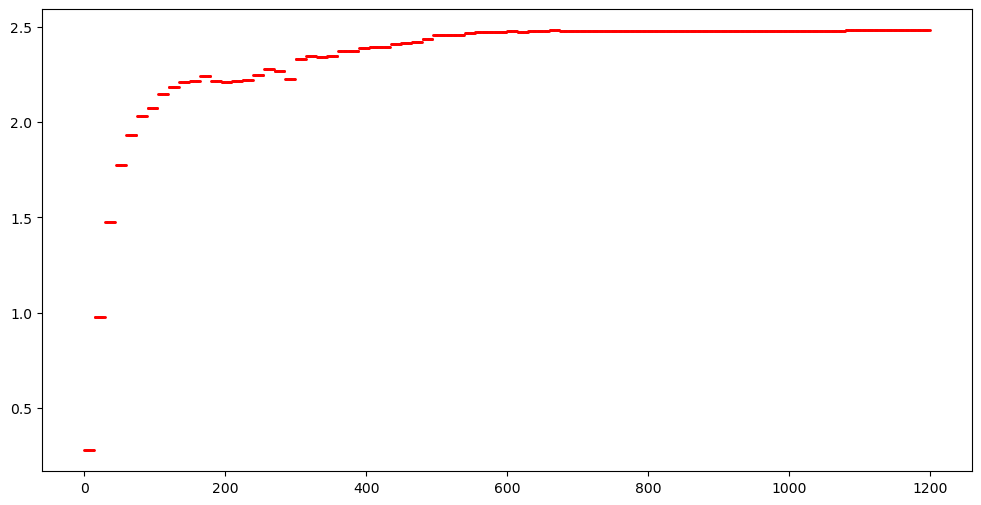

In [48]:
plt.figure(figsize=[12,6])
# plt.scatter(range(G1.size), G1.ravel(), s=2, c='r')
# plt.scatter(range(G2.size), G2.ravel(), s=2, c='b')

plt.scatter(range(m_output*n_rep*(T+num_init)), np.mean(G1e, axis=(0)).ravel(), s=1, c='r')
G2ee = np.tile(G2e, (m_output))
plt.scatter(range(m_output*n_rep*(T+num_init)), np.mean(G2ee, axis=(0)).ravel(), s=7, c='b')
# plt.title(f"trials={trials},init={num_init},m={m_output},n={n_rep},T={T}, maximum={-4.9}")
plt.title(f"1D function  m={m_output}", fontsize=15)
plt.xlabel("the number of function evaluations", fontsize=15)
plt.ylabel("$G(\hat{x}_{t}^{*})$", fontsize=13,rotation = 0, loc='bottom')

plt.legend(["MA-UCB", "benchmark"], loc=4, prop={'size': 20})

plt.savefig("D:\Jupyter_Projs//W//Hetero_GP//G_result_data/1D_m8.pdf", dpi=500, bbox_inches="tight")

In [25]:
# np.unique(np.where(G1e > 3.2375)[0])
# G1e[10].max(), G1e[37].max(), G1e[41].max()

In [8]:
## dump data
import pickle
save_path = f'D:\Jupyter_Projs//W//Hetero_GP//G_result_data//G_m{m_output}_' + f.__name__ 
print(save_path)
G_list = [G1e, G2e]
output = open(save_path, 'wb')
pickle.dump(G_list , output)
output.close()

D:\Jupyter_Projs//W//Hetero_GP//G_result_data//G_m8_g_sin1d


In [46]:
# read G  data
output = open("D://Jupyter_Projs//W//Hetero_GP//\G_result_data//G_m5_g_sin1d", 'rb')
G_list = pickle.load(output)
output.close()
G1e = G_list[0]
G2e = G_list[1]
G2ee = np.tile(G2e, (m_output))

In [47]:
G1e.shape, G2e.shape, G2ee.shape

((50, 80, 15), (50, 16, 15), (50, 16, 120))

In [9]:
# plt.figure(figsize=[12,6])
# # plt.scatter(range(G1.size), G1.ravel(), s=2, c='r')
# # plt.scatter(range(G2.size), G2.ravel(), s=2, c='b')

# plt.scatter(range(m_output*n_rep*(T+num_init)), np.mean(G1e, axis=(0)).ravel(), s=2, c='r')
# G2ee = np.tile(G2e, (m_output))
# plt.scatter(range(m_output*n_rep*(T+num_init)), np.mean(G2ee, axis=(0)).ravel(), s=2, c='b')
# plt.title(f"trials={trials},init={num_init},m={m_output},n={n_rep},T={T}, maximum={2.5995}")
# plt.xlabel("the number of function evaluations")
# plt.ylabel("$G(\hat{x}_{t}^{*})$", fontsize=10,rotation = 0, loc='bottom')

# plt.legend(["proposed", "benchmark"])

In [22]:
g1 = []
for x in design_X:
    z,g = f(x)
    g1.append(g)
    
max(g1)
# plt.scatter(design_X, g1)
# plt.scatter(design_X, 0.2 + design_X * 3)

tensor(3.2375, dtype=torch.float64)

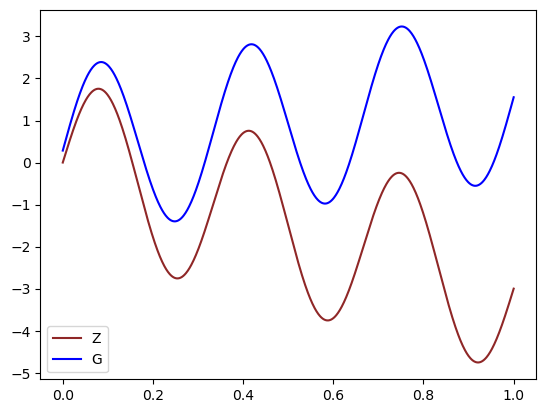

In [11]:
em3 = 0.846 
em5 = 1.163 
em8 = 1.42
# em10 = 1.540

# z = 2 * np.sin(6 * np.pi * x) - 3 * x
# noise = np.random.normal(loc=0, scale=(0.2 + x * 3), size=x.shape[0])
# sx = 0.2 + x * 3
# Gx = z + Em * sx

xp = np.linspace(0,1, 1000)
zxp = 2 * np.sin(6 * np.pi * xp) - 3 * xp
s_xp = 0.2 + xp * 3
Gx = zxp + Em * s_xp


light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"
#  0.846, 1.163, 1.42, 1.540
# plt.fill_between(xs, zxp-4*s_xp, zxp+1.540*s_xp, facecolor=light, color=light)
# plt.fill_between(xp, zxp-em8*s_xp, zxp+em8*s_xp, facecolor=light_highlight, color=light_highlight)
# plt.fill_between(xp, zxp-em5*s_xp, zxp+em5*s_xp,facecolor=mid, color=mid)
# plt.fill_between(xp, zxp-em3*s_xp, zxp+em3*s_xp, facecolor=mid_highlight, color=mid_highlight)
plt.plot(xp, zxp, color=dark)
plt.plot(xp, Gx, color="b")
# plt.scatter(xs, y_ob[0],s=4)
plt.legend(['Z', 'G'], loc=3)
# filename =  "example__.pdf"
# plt.savefig(filename, dpi=300)

In [12]:
# fig = plt.figure(figsize=[10, 8])  #定义新的三维坐标轴
# ax3 = plt.axes(projection='3d')


# #定义三维数据
# xx = np.arange(0,1,0.1)
# yy = np.arange(-10,10,0.1)
# X, Y = np.meshgrid(xx, yy)
# xp = X.reshape(-1, 1)
# yp = Y.reshape(-1, 1)
# f_in = np.hstack([xp, yp])

# Z = np.zeros_like(xp)
# G = np.zeros_like(xp)

# for i in range(Z.shape[0]):
#     Z[i] = ackley(f_in[i])[0]
#     G[i] = ackley(f_in[i])[1]
# #作图
# ax3.plot_surface(X,Y,Z.reshape(xx.shape[0], -1),rstride = 1, cstride = 1,cmap='rainbow')
# # ax3.contour(X,Y,Z.reshape(xx.shape[0], -1),offset=-1, cmap = 'rainbow')#绘制等高线

# plt.show()

In [13]:
# fig = plt.figure(figsize=[10, 8])  #定义新的三维坐标轴
# axG = plt.axes(projection='3d')

# axG.plot_surface(X,Y,G.reshape(xx.shape[0], -1),rstride = 1, cstride = 1,cmap='rainbow')
# plt.show()

#### Z fitting 

In [14]:
# xx = np.linspace(0,1, 1000).reshape(-1, 1)
# z = 2 * np.sin(6 * np.pi * xx) - 3 * xx
# m = []
# var = []

# for x in xx:
#     m.append(model_Z.posterior(torch.from_numpy(x)).mean.detach().numpy().ravel())
#     var.append(model_Z.posterior(torch.from_numpy(x)).variance.detach().numpy().ravel())

# plt.scatter(xx.ravel(), m)
# plt.scatter(xx.ravel(), z)

### L fitting

In [15]:
# xx = np.linspace(0,1, 1000).reshape(-1, 1)
# s = (0.2 + xx * 3)**2
# pi_l = np.log(s/(M_s-s))
# m = []
# var = []

# for x in xx:
#     m.append(model_L.posterior(torch.from_numpy(x)).mean.detach().numpy().ravel())
#     var.append(model_L.posterior(torch.from_numpy(x)).variance.detach().numpy().ravel())
    
# plt.scatter(xx.ravel(), m)
# plt.scatter(xx.ravel(), pi_l, c="r")

In [16]:
# var = (0.2+train_X*3) **2


# # for x in xx:
# #     m.append(model_L.posterior(torch.from_numpy(x)).mean.detach().numpy().ravel())
# #     var.append(model_L.posterior(torch.from_numpy(x)).variance.detach().numpy().ravel())
    
# plt.scatter(train_X.ravel(), train_yv.ravel())
# plt.scatter(train_X.ravel(), var.ravel(), c="r")

In [17]:
# ss  = 0
# for k,v in result_dic.items():
#     if v[0] > 1:
#         print(k, v)
# ss

In [18]:
# mm = []
# for i in range(30):
#     mm.append(f(np.array([0.9]))[0])
    
# var_m = np.std(mm, ddof=1)
# real_ = 0.2+0.9*3


In [19]:
# # read G  data
# output = open("D://Jupyter_Projs//W//Hetero_GP//result_data//g_sin1d_G", 'rb')
# G_list = pickle.load(output)
# output.close()
# G1e = G_list[0]
# G2e = G_list[1]

# # plot result
# plt.figure(figsize=[12,6])
# plt.scatter(range(m_output*n_rep*(T+num_init)), np.mean(G1e, axis=(0)).ravel(), s=2, c='r')
# G2ee = np.tile(G2e, (m_output))
# plt.scatter(range(m_output*n_rep*(T+num_init)), np.mean(G2ee, axis=(0)).ravel(), s=2, c='b')
# plt.title(f"trials={trials},init={num_init},m={m_output},n={n_rep},T={T}")
# plt.xlabel("the number of function evaluations")
# plt.ylabel("$G(\hat{x}_{t}^{*})$", fontsize=10,rotation = 0, loc='bottom')

# plt.legend(["proposed", "benchmark"])